![datiaperti logo](images/datiaperti_small.png)

# Geospatial Data Analysis - Raster Data
Geospatial data such as satellite imagery or elevation model are represented as one or more matrices of values. For example an image is usually represented as three matrices (bands) of values in the Red, Blue or Green colors. Each pixel of the image is represented by three RGB values. Satellite imagery may have more than three bands depending on the type of sensor used in the acquisition. Digital elevetion models (DEMs) and land cover models are represented as single band raster data. In this section we'll see how raster data can be read, processed and written in a file.

The upper-left corner of an image represents the origin (0, 0). The x axis goes from the origin to the left while the y axis goes from the origin to the bottom of the image. We use the [GDAL Python binding](https://gdal.org/tutorials/raster_api_tut.html)  to read and write GeoTIFF files that contain the raster data and metadata. We use the [PIL](https://pillow.readthedocs.io/en/stable/index.html) Python package to render the images and Matplotlib to visualize them in the notebook.

In [45]:
import os
import shutil
import glob
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
from ospybook.vectorplotter import VectorPlotter
vp = VectorPlotter(True)
%matplotlib inline

We want to stack three raster images, acquired by a Landsat satellite, into a GeoTIFF file so that they can be used as RGB bands. Let's have a look at one of them

In [9]:
#os.getcwd()
#os.chdir('..')

TIFF (8849, 8023) L


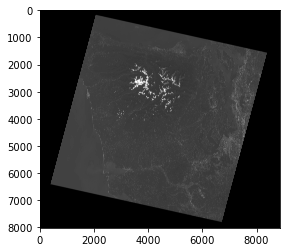

In [38]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = path + 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = path + 'p047r027_7t20000730_z10_nn30.tif'
im_band1 = Image.open(band1_fn)
print(im_band1.format, im_band1.size, im_band1.mode)
plt.imshow(im_band1, cmap='gray')

The image files are provided in GeoTIFF format with one single band so we extract information from their metadata such as the image size for each dimension, the spatial reference system and the coordinates of the origin.

In [20]:
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
in_band.XSize, in_band.YSize, in_band.DataType, in_ds.GetProjection()

(8849,
 8023,
 1,
 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [34]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = in_ds.GetGeoTransform()
print('x_origin: {}, y_origin: {}, pixel resolution: {}'.format(x_origin, y_origin, x_pixel_resolution))

x_origin: 343724.25, y_origin: 5369585.25, pixel resolution: 28.5


We create a new GeoTIFF file with three bands of the same size and spatial reference system as the images

In [22]:
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'nat_color.tif', in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

0

We copy the raster data of the 1st image into the 3rd band of the created GeoTIFF file

In [23]:
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

0

We open the 2nd image and we put the raster data into the 2nd band

In [24]:
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

0

Finally we put the 3rd image into the 1st band

In [25]:
in_ds = gdal.Open(band3_fn)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_ds.ReadAsArray())

0

we write the data on disk. If the file is a new one we have to close the data source as well.

In [28]:
out_ds.FlushCache() 

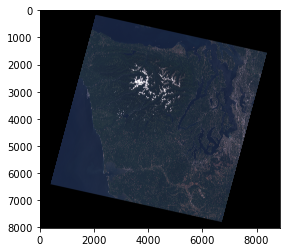

In [39]:
im_natcol = Image.open(path + 'nat_color.tif')
plt.imshow(im_natcol)

we compute some statistical values for each band: mean, min, max and standard deviation. We create also some overview layers for each band to be visualized at different zoom levels.

In [30]:
for i in range(1, 4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)
    out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])
del out_ds

### Raster data subsetting
Satellite imagery cover large areas of the Earth surface. If we are interested only in a subset of such areas it is worthwhile to copy that subset in a new file in order to reduce its processing time.  

Let's say we are interested only in the area covered by the snow in the Landsat band1 imagery we have used in the previous section. In order to select an area inside the original image we have to apply an affine transformation that copies the pixels in the original image to the new one keeping the same metrics (i.e. distance). The affine transformation we are going to define is more precisely a translation, that is we will not apply any rotation.

In [3]:
band1_ds = gdal.Open(band1_fn)
x_offset, x_resolution, x_rotation, y_offset, y_rotation, y_resolution = band1_ds.GetGeoTransform()
print('x_offset: {} m, y_offset: {} m, x_resolution: {} m, y_resolution: {} m'.format(x_offset, y_offset, x_resolution, abs(y_resolution)))

x_offset: 343724.25 m, y_offset: 5369585.25 m, x_resolution: 28.5 m, y_resolution: 28.5 m


In [4]:
band1 = band1_ds.GetRasterBand(1)
print(band1.XSize, band1.YSize)
x_length = band1.XSize * x_resolution
y_length = band1.YSize * y_resolution
print('x length: {:.1f} km, y length: {:.1f} km'.format(x_length / 1000, abs(y_length) / 1000))

8849 8023
x length: 252.2 km, y length: 228.7 km


We want to move the offset of the subset image 90 km to the east and 60 km to the south. We need to compute the transformation that will be used to create the subset image. The spatial resolution for both x and y dimension will stay the same.

In [5]:
x_delta = 90000
y_delta = -60000
x_subset_offset = x_offset + x_delta # meter
y_subset_offset = y_offset + y_delta # meters
subset_transform = [x_subset_offset, x_resolution, x_rotation, y_subset_offset, y_rotation, y_resolution]
subset_transform

[433724.25, 28.5, 0.0, 5309585.25, 0.0, -28.5]

Then we want the length of the subset image to be 20 km to the east and 30 km to the south

In [6]:
x_subset_length = 30000 # meters
y_subset_length = 30000 # meters

We need to compute the number of pixels that corresponds to the size of the image for each direction

In [7]:
x_window_length = round(x_subset_length / x_resolution)
y_window_length = round(y_subset_length / abs(y_resolution))
x_window_length, y_window_length

(1053, 1053)

We also need to compute the pixel indexes that corresponds to the new offset 

In [8]:
x_window_start = round(x_delta / x_resolution)
y_window_start = round(abs(y_delta / y_resolution))
x_window_start, y_window_start

(3158, 2105)

We create a new GeoTiff file for the image subset, with one band and the size we want. We also set the offset of the subset image in the file metadata. We will use the same spatial reference system and the same spatial resolution in both x and y direction.

In [9]:
gtiff_driver = gdal.GetDriverByName('GTiff')
subset_ds = gtiff_driver.Create(path + 'subset.tif', xsize=x_window_length, ysize=y_window_length, bands=1, eType=band1.DataType)
subset_ds.SetProjection(band1_ds.GetProjection())
subset_ds.SetGeoTransform(subset_transform)
subset_band = subset_ds.GetRasterBand(1)

In [11]:
data = band1.ReadAsArray()
rows_start = y_window_start
rows_end = y_window_start + y_window_length
cols_start = x_window_start
cols_end = x_window_start + x_window_length
subset_data = data[rows_start:rows_end, cols_start:cols_end]
print(np.shape(subset_data))
subset_band.WriteArray(subset_data)
subset_ds.FlushCache() 
subset_ds = None
band1_ds = None

(1053, 1053)


Now we can plot the subset image

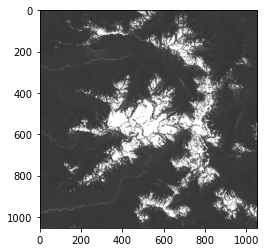

In [40]:
subset_img = Image.open(path + 'subset.tif')
plt.imshow(subset_img, cmap='gray')

### Georeferencing
We want to assign a spatial reference system to an image. For this task we use some ground control points. The procedure is explained in the [QGIS User Guide](https://docs.qgis.org/3.16/en/docs/user_manual/working_with_raster/georeferencer.html). As a simple example we will refer an image to the WGS84 geographic (unprojected) reference system. The example image does not have any spatial reference system so it cannot be overlaid onto a map, for example using QGIS, because the software doesn't know where it should be put.

In [13]:
orig_fn = r'data\raster\Utah\cache_no_gcp.tif'
fn = r'data\raster\Utah\cache.tif'
shutil.copy(orig_fn, fn)
ds = gdal.Open(fn, gdal.GA_Update)
sr = osr.SpatialReference()
sr.SetWellKnownGeogCS('WGS84')

0

We need at least three ground control points: we will use four, with their coordinates referenced to WGS84. For each point we need its x, y, and z coordinates and the row and column of the pixel in the image that refers to the ground point. The GDAL library uses the GCPs to compute the coefficients of the affine transformation that will map a pixel to a point in the spatial reference system.

$$ E = a_{11}x + a_{12}y + t_E $$
$$ N = a_{21}x + a_{22}y + t_N $$

Here x and y represent the pixel indexes, E and N are the spatial coordinates, often referred to as easting and northing. The coefficients $a_{ij}$ represent rotation and scale, $t_E$ and $t_N$ represent a translation. Each ground control point defines two linear equations of 6 unknown coefficients so we need at least three GCP to solve the linear system of 6 equations in 6 unknown coefficients. Since the GCPs may not be precise it is usually recommended to use more than three GCPs and compute the best approximation to the real value by minimizing the root mean square errors (RMSE) between the real spatial coordinates and the coordinates computed using the affine transformation.    

In [14]:
gcps = [gdal.GCP(-111.931075, 41.745836, 0, 1078, 648),
        gdal.GCP(-111.901655, 41.749269, 0, 3531, 295),
        gdal.GCP(-111.899180, 41.739882, 0, 3722, 1334),
        gdal.GCP(-111.930510, 41.728719, 0, 1102, 2548)]

ds.SetGCPs(gcps, sr.ExportToWkt())
ds = None

The image copy has now a reference system and can be overlaid onto a map.

### Mosaicking
We want to join together images to cover an area that is partially covered by a set of small images. The composition is called a mosaic. The extension of the mosaic is computed from the images by finding the minimum and maximum values of the spatial coordinates x and y so that we can define the mosaic bounding box with two points: (min_x, max_y), (max_x, min_y). For this example we will use the [Massachusetts](https://app.box.com/s/1cwdnolsmtf0s04o0hshbv4vxiuqcmi9/file/45898207309) dataset provided by C. Garrard. The zip file must be unzipped in a folder like in the example. There are 6 images that we want to merge in one single mosaic image.

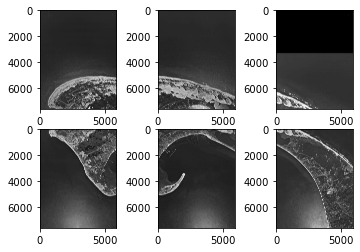

In [42]:
path_mosaic = 'data/raster/Massachusetts/'
img1 = Image.open(path_mosaic + 'O4207063.NWS.916803.tif')
img2 = Image.open(path_mosaic + 'O4207063.NES.916802.tif')
img3 = Image.open(path_mosaic + 'O4207064.NWS.916806.tif')
img4 = Image.open(path_mosaic + 'O4207063.SWS.916805.tif')
img5 = Image.open(path_mosaic + 'O4207063.SES.916804.tif')
img6 = Image.open(path_mosaic + 'O4207064.SWS.916808.tif')

f, axarr = plt.subplots(2,3)
axarr[0, 0].imshow(img1, cmap='gray')
axarr[0, 1].imshow(img2, cmap='gray')
axarr[0, 2].imshow(img3, cmap='gray')
axarr[1, 0].imshow(img4, cmap='gray')
axarr[1, 1].imshow(img5, cmap='gray')
axarr[1, 2].imshow(img6, cmap='gray')

This function computes the min and max x (eastings) and y (northing) coordinates of an image. The units are in meters.

In [43]:
def get_extent(fn):
    '''Returns min_x, max_y, max_x, min_y'''
    ds = gdal.Open(fn)
    x_min, x_resolution, x_rotation, y_max, y_rotation, y_resolution = ds.GetGeoTransform()
    x_max = x_min + x_resolution * ds.RasterXSize # RasterXSize is the length in pixels of the image in the x dimension
    y_min = y_max + y_resolution * ds.RasterYSize
    print('File {} - x_min: {} m, y_max: {} m, x_max: {} m, y_min: {} m'.format(fn, x_min, y_max, x_max, y_min))
    return (x_min, y_max, x_max, y_min)

In [44]:
os.chdir('data/raster/Massachusetts')

We compute the min and max of the mosaic image coordinates

In [45]:
in_files = glob.glob('O*.tif') # looks for files names starting with 'O' and with extension .tif
x_min, y_max, x_max, y_min = get_extent(in_files[0])
for fn in in_files[1:]:
    minx, maxy, maxx, miny = get_extent(fn)
    x_min = min(x_min, minx)
    y_max = max(y_max, maxy)
    x_max = max(x_max, maxx)
    y_min = min(y_min, miny)

print('x_min: {} m, y_max: {} m, x_max: {} m, y_min: {} m'.format(x_min, y_max, x_max, y_min))

File O4207063.NES.916802.tif - x_min: 401449.0 m, y_max: 4664648.0 m, x_max: 407356.0 m, y_min: 4657027.0 m
File O4207063.NWS.916803.tif - x_min: 396278.0 m, y_max: 4664722.0 m, x_max: 402190.0 m, y_min: 4657097.0 m
File O4207063.SES.916804.tif - x_min: 401353.0 m, y_max: 4657709.0 m, x_max: 407265.0 m, y_min: 4650088.0 m
File O4207063.SWS.916805.tif - x_min: 396177.0 m, y_max: 4657782.0 m, x_max: 402094.0 m, y_min: 4650158.0 m
File O4207064.NWS.916806.tif - x_min: 406620.0 m, y_max: 4664578.0 m, x_max: 412522.0 m, y_min: 4656961.0 m
File O4207064.SWS.916808.tif - x_min: 406529.0 m, y_max: 4657639.0 m, x_max: 412436.0 m, y_min: 4650022.0 m
x_min: 396177.0 m, y_max: 4664722.0 m, x_max: 412522.0 m, y_min: 4650022.0 m


We compute the number of pixels of the mosaic in the the x and y dimensions 

In [46]:
in_ds = gdal.Open(in_files[0])
x_offset, x_resolution, x_rotation, y_offset, y_rotation, y_resolution = in_ds.GetGeoTransform()
rows = math.ceil((y_max - y_min) / abs(y_resolution))
cols = math.ceil((x_max - x_min) / x_resolution)
print('mosaic x size: {}, y size: {}'.format(cols, rows))

mosaic x size: 16345, y size: 14700


We create a raster GeoTIFF file for the mosaic image 

In [47]:
driver = gdal.GetDriverByName('GTiff')
mosaic_ds = driver.Create('mosaic.tif', cols, rows)

In [48]:
mosaic_ds.SetProjection(in_ds.GetProjection())
mosaic_band = mosaic_ds.GetRasterBand(1)

We set the offset of the mosaic image, that is the spatial coordinates of the upper-left corner pixel 

In [49]:
mosaic_transform = [x_min, x_resolution, x_rotation, y_max, y_rotation, y_resolution]
mosaic_ds.SetGeoTransform(mosaic_transform)

0

Now we loop through all the images to copy the pixels in the mosaic image. Since the spatial reference is the same and the GeoTIFF files contain all the information required we can use a GDAL function to do the job.

In [50]:
for fn in in_files:
    in_ds = gdal.Open(fn)
    trans = gdal.Transformer(in_ds, mosaic_ds, [])
    success, xyz = trans.TransformPoint(False, 0, 0)
    x, y, z = map(int, xyz)
    data = in_ds.GetRasterBand(1).ReadAsArray()
    mosaic_band.WriteArray(data, x, y)
    in_ds = None
mosaic_ds = None

We can now plot the mosaic

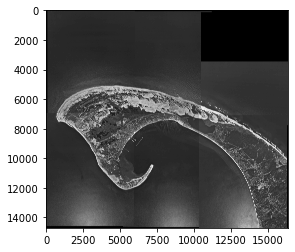

In [51]:
Image.MAX_IMAGE_PIXELS = None
mosaic_img = Image.open('mosaic.tif')
plt.imshow(mosaic_img, cmap='gray')

### Color Tables
Raster data can be used not only to record observations from a sensor, such as the reflectance of a surface, but also to assign values to areas on the Earth surface. For example the value of a pixel may represent the height at the pixel location. Another example is land use and land cover classification, in which a pixel value represents the class of an area, according to some classification criteria. In the example We use the [Switzerland](https://app.box.com/s/1cwdnolsmtf0s04o0hshbv4vxiuqcmi9/file/40585692217) dataset provided by C. Garrard. The file contains the heights in Switzerland in a very coarse scale of only 5 different values. We want to assign a color to each pixel depending on its value so that it will be possible to visualize the areas that belong to each height class. Unzip the file in a folder like in the example.

In [54]:
os.getcwd()
#os.chdir(r'..\Switzerland')

'C:\\cygwin64\\home\\Luigi\\geoscience\\data\\raster\\Switzerland'

We plot the elevation model using the Python PIL package that will assign automatically a color to each value between 1 and 5 on a gray scale and black to pixels with no data. 

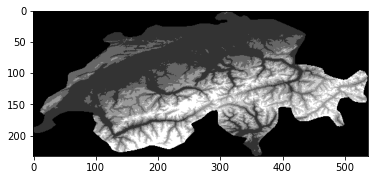

In [55]:
orig_img = Image.open('dem_class.tif')
plt.imshow(orig_img, cmap='gray')

We want to assign colors that have a meaning for us. We make a copy of the file so that the original one will not be changed.

In [56]:
original_ds = gdal.Open('dem_class.tif')
driver = gdal.GetDriverByName('gtiff')
ds = driver.CreateCopy('dem_class2.tif', original_ds)
band = ds.GetRasterBand(1)

We create an RGB color table. One RGB color for each value, from 1 to 5, of the pixels.

In [57]:
colors = gdal.ColorTable()
colors.SetColorEntry(1, (112, 153, 89))
colors.SetColorEntry(2, (242, 238, 162))
colors.SetColorEntry(3, (242, 206, 133))
colors.SetColorEntry(4, (194, 140, 124))
colors.SetColorEntry(5, (214, 193, 156))

We set the color table of the dataset

In [58]:
band.SetRasterColorTable(colors)
band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)
band = None
ds = None

We can now plot the map with colors that represent the height at each location: green for flat land and brown for mountain areas.

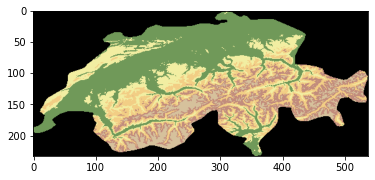

In [59]:
color_img = Image.open('dem_class2.tif')
plt.imshow(color_img)

### Histograms
Histograms are used to analyze the distribution of pixel values. The GetHistogram() method of the GDAL Python binding can be used to compute a histogram of a raster file by setting the min and max pixel values, the number of buckets and other parameters.

In [98]:
#os.getcwd()
#os.chdir(r'data\Switzerland')

We set the parameters for GetHistogram() including the parameter to get an exact histogram (approx_ok=False) and to not include values out of range (include_out_of_range=False). The pixel values of the raster containing the Swiss elevation model range between 1 and 5 and we have to include the no data value that is assigned the integer value 0. So we need 7 buckets. Five buckets for each of the integer value used to represent the height, and two more buckets to represent the pixel values below or above our interval. In our example these two buckets will be empty.

In [84]:
ds = gdal.Open('dem_class2.tif')
band = ds.GetRasterBand(1)
hist = band.GetHistogram(min=-0.5, max=6.5, buckets=7, include_out_of_range=False, approx_ok=False)
print('Histogram:', hist[:7], sum(hist))

Histogram: [0, 27213, 12986, 13642, 10632, 5414, 0] 69887


<BarContainer object of 7 artists>

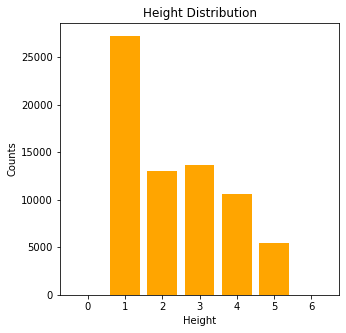

In [97]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title("Height Distribution")
ax.set_xlabel("Height")
ax.set_ylabel("Counts");
interval = range(0, 7, 1)
plt.bar(interval, hist, color='orange')

### Map Algebra
We might need to apply some algebric operation to a set of one or more raster files. The operation will be performed using NumPy arrays and the data will be saved as raster GeoTIFF files. We will use the following function to create a GeoTIFF file from a NumPy array.

In [3]:
def make_raster(in_ds, fn, data, data_type, nodata=None):
    """Create a one-band GeoTIFF.
    in_ds: datasource to copy projection and geotransform from
    fn: path to the file to create
    data: NumPy array containing data to write
    data_type: output data type
    nodata: optional NoData value
    """
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(fn, in_ds.RasterXSize, in_ds.RasterYSize, 1, data_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_band = out_ds.GetRasterBand(1)
    if nodata is not None:
        out_band.SetNoDataValue(nodata)
    out_band.WriteArray(data)
    out_band.FlushCache()
    out_band.ComputeStatistics(False)
    return out_ds

One example operation is the computation of the Normalized Difference Vegetation Index (NDVI) from two raster images, one containing the near-infrared (NIR) reflactance values and another containing the visible red band.

$$NDVI = \frac{NIR - RED}{NIR + RED}$$

In [3]:
#os.getcwd()
os.chdir(r'data\raster\Massachusetts')

We use a GeoTIFF file that contains the near-infrared and the red bands.

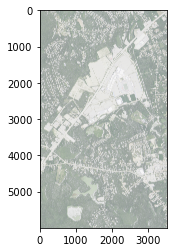

In [4]:
in_fn = 'm_4207162_ne_19_1_20140718_20140923_clip.tif'
orig_img = Image.open(in_fn)
plt.imshow(orig_img)

We compute the NDVI index for each pixel and then we store the result in a new GeoTIFF file

In [25]:
ndvi_fn = 'ndvi.tif'
ds = gdal.Open(in_fn)
red = ds.GetRasterBand(1).ReadAsArray().astype(float)
nir = ds.GetRasterBand(4).ReadAsArray()
red = np.ma.masked_where(nir + red == 0, red)
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.filled(-999) * 1000 # fill the empty cells and re-scale the values
ndvi_ds = make_raster(ds, ndvi_fn, ndvi, gdal.GDT_Float32, -99)
del ds, ndvi_ds

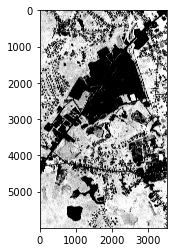

In [26]:
ndvi_img = Image.open(ndvi_fn)
plt.imshow(ndvi_img, cmap='gray')

#### Focal Analysis
We might be interested in finding patterns in the raster data or we may want to fill missing values or smooth the data. One typical case is to remove speckle in radar images. In order to accomplish any of these tasks we have to define a pixel's neighborhood and compute a function or statistics over it repeating the same operation by moving to the next pixel. The result will be a new raster data. One simple neighborhood is a square centered in a pixel, e.g. a 3x3 square. The statistics can be the mean value, the maximum value or many other. Using nested for loops to process an image is not recommended. A better approach is to create slices of the image, stack the slices in a three-dimensional array and then compute the function, e.g. sum or average. The number of slices depends on the window size. For example for a 3x3 square window 9 slices are needed.  

In [2]:
def make_slices(data, win_rows, win_cols):
    """Return a list of slices given a window size.
    data: two-dimensional array to get slices from
    win_size: tuple of (rows, columns) for the moving window
    """
    rows = data.shape[0] - win_rows + 1
    cols = data.shape[1] - win_cols + 1
    slices = []
    for i in range(win_rows):
        for j in range(win_cols):
            slices.append(data[i:rows + i, j:cols + j])
    return slices

As an example, we use the digital elevation model (DEM) of an area around Mount Everest. We will compute a smoothed version of the DEM by averaging the pixel values in a neighborohood of 3x3 pixels. We visualize the DEM

(139, 111)


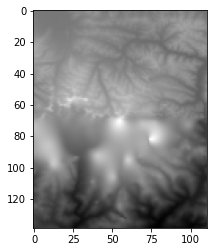

In [4]:
in_ds = gdal.Open('data/raster/Nepal/everest.tif')
in_band = in_ds.GetRasterBand(1)
in_data = in_band.ReadAsArray()
print(in_data.shape)
plt.imshow(in_data, cmap='gray')

We create the slices using the make_slices() function, then we stack them in a three-dimensional array

In [5]:
slices = make_slices(in_data, 3, 3)
stacked_data = np.ma.dstack(slices)
stacked_data.shape

(137, 109, 9)

We compute the mean value by averaging each pixel in the slices along the stack. This result is the same as averaging the values of the neighbors of each pixel.

In [6]:
rows, cols = in_band.YSize, in_band.XSize
out_data = np.ones((rows, cols), np.int32) * -99 # initialize the output to NoData (i.e.: -99)
out_data[1:-1, 1:-1] = np.mean(stacked_data, 2) # computes the mean along the stack dimension
out_fn = r'data/raster/Nepal/everest_smoothed.tif'
make_raster(in_ds, out_fn, out_data, gdal.GDT_Int32, -99)
in_ds = None

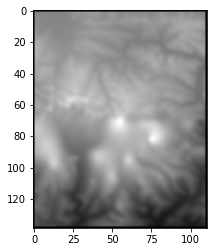

In [9]:
smoothed_ds = gdal.Open(out_fn)
smoothed_band = smoothed_ds.GetRasterBand(1)
smoothed_data = smoothed_band.ReadAsArray()
plt.imshow(smoothed_data, cmap='gray')
smoothed_ds = None

We can use the same approach to compute the slope, i.e. the gradient, at each point of the DEM. To compute the average value of a 3x3 window around each pixel we had to compute the sum of the slices and divide by 9. We used the mean() function available in the NumPy package but that is the result. Now we use the slices to compute the DEM derivatives in the x and y directions.

In [46]:
in_fn = r'data/raster/Nepal/everest_utm.tif'
out_fn = r'data/raster/Nepal/everest_slope.tif'
in_ds = gdal.Open(in_fn)
cell_width = in_ds.GetGeoTransform()[1]
cell_height = in_ds.GetGeoTransform()[5]
band = in_ds.GetRasterBand(1)
in_data = band.ReadAsArray().astype(np.float64)
out_data = np.ones((band.YSize, band.XSize)) * -99 # initialize the output to NoData (i.e.: -99)
slices = make_slices(in_data, 3, 3)
dem_dx = ((slices[6] + (2 * slices[7]) + slices[8]) - (slices[0] + (2 * slices[1]) + slices[2])) / (8 * cell_height)
dem_dy = ((slices[2] + (2 * slices[5]) + slices[8]) - (slices[0] + (2 * slices[3]) + slices[6])) / (8 * cell_width)
dist = np.sqrt(np.square(dem_dx) + np.square(dem_dy))
out_data[1:-1, 1:-1] = np.arctan(dist) * 180 / np.pi
make_raster(in_ds, out_fn, out_data, gdal.GDT_Float32, -99)
in_ds = None

We can now plot the slope, the gradient of the digital elevation model 

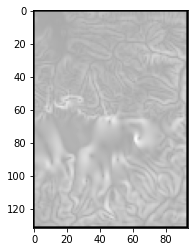

In [47]:
slope_ds = gdal.Open(out_fn)
slope_band = slope_ds.GetRasterBand(1)
slope_array = slope_band.ReadAsArray()
plt.imshow(slope_array, cmap='gray')
slope_ds = None

We can also use [SciPy](https://scipy.github.io/devdocs/tutorial/ndimage.html) to apply different filters to a raster file. For example we can apply a smoothing filter (uniform_filter() in SciPy) to the DEM of Mount Everest  

In [10]:
import scipy.ndimage

In [11]:
in_fn = 'data/raster/Nepal/everest.tif'
out_fn = r'data/raster/Nepal/everest_smoothed.tif'
in_ds = gdal.Open(in_fn)
in_data = in_ds.GetRasterBand(1).ReadAsArray()
out_data = scipy.ndimage.filters.uniform_filter(in_data, size=3, mode='nearest')
make_raster(in_ds, out_fn, out_data, gdal.GDT_Int32)
in_ds = None

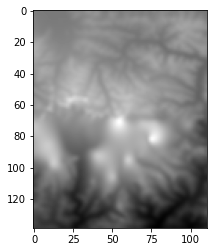

In [12]:
smoothed_ds = gdal.Open(out_fn)
smoothed_band = smoothed_ds.GetRasterBand(1)
smoothed_data = smoothed_band.ReadAsArray()
plt.imshow(smoothed_data, cmap='gray')
smoothed_ds = None

#### Zonal Analysis
Zonal analysis is performed using two raster images. One image defines the zones while the second image provides the data to be used within those zones. A zone can also be provided as vector data.  

In [15]:
import scipy.stats

In [21]:
def get_bins(data):
    """Return bin edges for all unique values in data."""
    bins = np.unique(data)
    return np.append(bins, max(bins) + 1)

In [22]:
landcover_fn = r'data/raster/Utah/landcover60.tif'
ecoregion_fn = r'data/raster/Utah/utah_ecoIII60.tif'
out_fn = r'data/raster/Utah/histogram.csv'

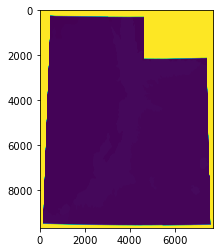

In [39]:
eco_ds = gdal.Open(ecoregion_fn)
eco_band = eco_ds.GetRasterBand(1)
eco_data = eco_band.ReadAsArray()
eco_bins = get_bins(eco_data)
plt.imshow(eco_data)

82


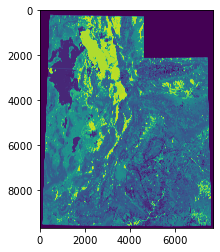

In [42]:
lc_ds = gdal.Open(landcover_fn)
lc_band = lc_ds.GetRasterBand(1)
lc_data = lc_band.ReadAsArray()
lc_bins = get_bins(lc_data)
print(len(lc_bins))
plt.imshow(lc_data)

In [43]:
hist, eco_bins2, lc_bins2, bn = scipy.stats.binned_statistic_2d(eco_data.flatten(), lc_data.flatten(), lc_data.flatten(), 'count', [eco_bins, lc_bins])
hist = np.insert(hist, 0, lc_bins[:-1], 0)
row_labels = np.insert(eco_bins[:-1], 0, 0)
hist = np.insert(hist, 0, row_labels, 1)
np.savetxt(out_fn, hist, fmt='%1.0f', delimiter=',')

Another way to compute the histogram using NumPy

In [54]:
hist, zone_bins, landcover_bins = np.histogram2d(eco_data.flatten(), lc_data.flatten(), [get_bins(eco_data), get_bins(lc_data)])

In [62]:
hist[0].shape

(81,)

In [56]:
landcover_bins.shape

(82,)

We plot the data as a bar chart (to be completed)

<BarContainer object of 81 artists>

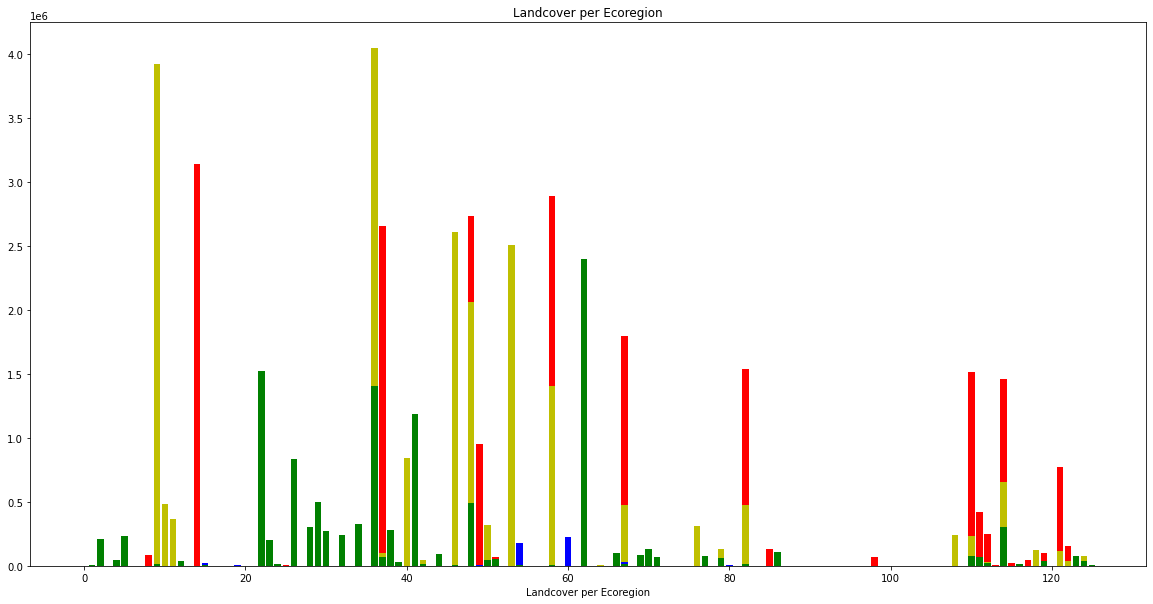

In [84]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Landcover per Ecoregion")
ax.set_xlabel("Landcover per Ecoregion")
ax.set_ylabel("");
plt.bar(landcover_bins[:-1], hist[0], color='c')
plt.bar(landcover_bins[:-1], hist[1], color='g')
plt.bar(landcover_bins[:-1], hist[2], color='r')
plt.bar(landcover_bins[:-1], hist[3], color='y')
plt.bar(landcover_bins[:-1], hist[4], color='b')
plt.bar(landcover_bins[:-1], hist[5], color='g')

#### Global Analysis
The output of a global analysis is a function of all the input raster data. An example is the cost allocation (or distance) of traveling from a source cell. The cost associated to travel from a source cell to any other cell on a flat surface can be calculated using the Eucledean distance for each cell. In case the surface is not flat the cost will be different, depending on the elevation of the cell. As an example we use a vector dataset containing wilderness areas in Idaho and other areas in the US and another vector dataset contaning all the Idaho roads. We are interested in calculating the shorter distance to a road from each cell in a wilderness area of Idaho. This type of analysis is called proximity analysis. The first step to start the computation of the distances is to convert the roads vector data into raster. The conversion is calles 'rasterization'. 

In [28]:
folder = r'data/raster/Idaho'
roads_ln = 'allroads' # vector dataset containing the roads of Idaho
wilderness_ln = 'wilderness' # vector dataset of wilderness in a larger area of the US
road_raster_fn = 'church_roads.tif'
proximity_fn = 'proximity.tif'
cellsize = 10

Get extent of wilderness area

In [34]:
shp_ds = ogr.Open(folder)
wild_lyr = shp_ds.GetLayerByName(wilderness_ln)
wild_lyr.SetAttributeFilter("WILD_NM = 'Frank Church - RONR'")
envelopes = [row.geometry().GetEnvelope() for row in wild_lyr]
coords = list(zip(*envelopes))
minx, maxx = min(coords[0]), max(coords[1])
miny, maxy = min(coords[2]), max(coords[3])
print(minx, maxx)

2347778.078370039 2470558.146773548


Select roads in wilderness extent

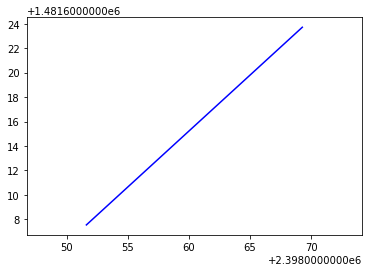

In [46]:
road_lyr = shp_ds.GetLayerByName(roads_ln)
road_lyr.SetSpatialFilterRect(minx, miny, maxx, maxy)
road_lyr.GetSpatialRef()
road_feature = road_lyr.GetNextFeature()
road_geometry = road_feature.geometry().Clone()
vp.plot(road_geometry, 'b')

In [36]:
#os.chdir('..')
#os.getcwd()

In [38]:
tif_driver = gdal.GetDriverByName('GTiff')
cols = int((maxx - minx) / cellsize)
rows = int((maxy - miny) / cellsize)
rows, cols

(14804, 12278)

Create empty raster for roads

In [40]:
road_ds = tif_driver.Create(road_raster_fn, cols, rows)
road_ds.SetProjection(road_lyr.GetSpatialRef().ExportToWkt())
road_ds.SetGeoTransform((minx, cellsize, 0, maxy, 0, -cellsize))

0

Burn roads into raster

In [41]:
gdal.RasterizeLayer(road_ds, [1], road_lyr, burn_values=[1], callback=gdal.TermProgress)

RuntimeError: Object given is not a Python function

Burn proximity data into raster

In [42]:
prox_ds = tif_driver.Create(proximity_fn, cols, rows, 1, gdal.GDT_Int32)
prox_ds.SetProjection(road_ds.GetProjection())
prox_ds.SetGeoTransform(road_ds.GetGeoTransform())
gdal.ComputeProximity(road_ds.GetRasterBand(1), prox_ds.GetRasterBand(1), ['DISTUNITS=GEO'], gdal.TermProgress)

RuntimeError: Object given is not a Python function

Burn wilderness into temporary raster

In [43]:
wild_ds = gdal.GetDriverByName('MEM').Create('tmp', cols, rows)
wild_ds.SetProjection(prox_ds.GetProjection())
wild_ds.SetGeoTransform(prox_ds.GetGeoTransform())
gdal.RasterizeLayer(wild_ds, [1], wild_lyr, burn_values=[1],callback=gdal.TermProgress)

RuntimeError: Object given is not a Python function

Set NoData outside wilderness

In [24]:
wild_data = wild_ds.ReadAsArray()
prox_data = prox_ds.ReadAsArray()
prox_data[wild_data == 0] = -99
prox_ds.GetRasterBand(1).WriteArray(prox_data)
prox_ds.GetRasterBand(1).SetNoDataValue(-99)
prox_ds.FlushCache()

In [25]:
stats = prox_ds.GetRasterBand(1).ComputeStatistics(False, gdal.TermProgress)
print('Mean distance from roads is', stats[2])
del prox_ds, road_ds, shp_ds

RuntimeError: Object given is not a Python function